4105056028 資工三 賈慶郁<br>
說明：改動了部分程式碼；註解寫於程式碼後以及段落間的 markdown cell 內

# Topic : Deep Learning 手寫辨認 using CNN 

## Step 0: Set the environment
前置作業，安裝 python 套件: tensorflow, keras, matplotlib, pandas

In [0]:
## need 1.8.0 tensorflow
# !pip install tensorflow==1.8.0
# !pip install keras
# !pip install matplotlib
# !pip install pandas

## Step 1: Loading data and  tensorflow and keras 

### Step 1-1: Data Loading
載入套件，跳出的紅色訊息說明 Keras 背後是使用 Tensorflow (或是Theano) 當做底層運算架構

In [2]:
import tensorflow as tf
import keras

print("tensorflow version == ",tf.__version__)
print("keras version == ",keras.__version__)

tensorflow version ==  1.15.0
keras version ==  2.2.5


Using TensorFlow backend.


### Step 1-2 : Loading dataset
載入 keras 常用 datasets：mnist 手寫字符數據集。<br>
- 訓練集：
    - Xtrain
        - 包含60,000張28x28像素灰階圖像
        - 圖片由numpy陣列構成
        - 圖片的像素範圍是[0,255]，所以datatype默認為uint8
    - Ytrain
        - 數字標籤所構成的陣列(datatype=uint8)，數字標籤為[0-9]共10類
- 測試集：
    - Xtest
        - 包含10,000張28x28像素灰階圖像
        - 圖片由numpy陣列構成
        - 圖片的像素範圍是[0,255]，所以datatype默認為uint8
    - Ytest
        - 數字標籤所構成的陣列(datatype=uint8)，數字標籤為[0-9]共10類

In [3]:
# 引入 Mnist 手寫字符數據集
from keras.datasets import fashion_mnist
#from keras.datasets import mnist

# 載入 Mnist 手寫辨識資料
(Xtrain,Ytrain),(Xtest,Ytest)=fashion_mnist.load_data()
type(Xtrain)
print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain[0].dtype)

XtrainO=Xtrain.copy()
YtrainO=Ytrain.copy()
XtestO=Xtest.copy()
YtestO=Ytest.copy()

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
uint8


import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(plt.imshow(Xtrain[0],cmap='binary'))


### Step 1-3: Exam Data : show Figures

In [0]:
# 數據資料視覺化
import matplotlib.pyplot as plt

In [0]:
# 可以內嵌繪圖，省略掉 plt.show()
%matplotlib inline

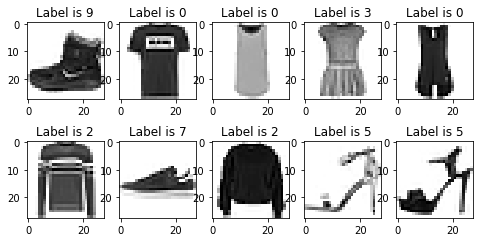

In [6]:
fig=plt.gcf()               # get current figure
fig.set_size_inches(8,4)    # 設置圖像長寬的具體尺寸(英吋)

for i in range(10):
    ax=plt.subplot(2,5,i+1) # 圖像視窗分為 2 rows 5 column，當前位置為 i+1
    ax.imshow(Xtrain[i], cmap='binary')
    ax.set_title('Label is {a}'.format(a=Ytrain[i]))

# plt.show()

# Step 2: Prepare X, Y 

由於圖片通常是RGB三個顏色所組成的，假設圖片大小是28\*28的彩色圖片，實際上的資料維度就是28\*28\*3。<br>
不過這邊數字的顏色都是單色因此我們轉成28\*28\*1的資料維度當作未來CNN Model的input

In [7]:
# 增加一個顏色的維度(1 維 :黑白)
Xtrain4D=Xtrain.reshape(60000,28,28,1).astype('float32')
Xtest4D=Xtest.reshape(10000,28,28,1).astype('float32')

# normolize the datasets
# 並將 255-pixel 的資料做正規化，使資料全部落在0到1之間
Xtrain4Dn=Xtrain4D/255
Xtest4Dn=Xtest4D/255
print('Xtrain4Dn shape=',Xtrain4Dn.shape,' type=',type(Xtrain4Dn),'dtype',Xtrain4Dn.dtype)

Xtrain4Dn shape= (60000, 28, 28, 1)  type= <class 'numpy.ndarray'> dtype float32


In [8]:
from keras.utils import np_utils as kerasTool
YtrainO=Ytrain.copy()

# 當特徵不是連續值，而是分類值且沒有大小順序之分
# 把類別資料做 onehot-encoding 處理，將 label 轉成向量
YtrainOneHot=kerasTool.to_categorical(Ytrain)
YtestOneHot=kerasTool.to_categorical(Ytest)

print('YtrainOneHot shape=',YtrainOneHot.shape,' type=',type(YtrainOneHot),'dtype',YtrainOneHot.dtype)

YtrainOneHot shape= (60000, 10)  type= <class 'numpy.ndarray'> dtype float32


# Step 3: Build Neural Network Model of Keras

### Step3-1: Model structure define
建立一個卷積圖像分類模型。<br>
這裡使用 Sequential 模型（最簡單的一種模型），其中張量將一層一層傳遞到下一層。

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
#========= extract features using CNN ==============
# 建立簡單的線性執行的模型
model = Sequential()

# 增加一個二維卷積層Conv2D，卷積在圖片上滑動率波來學習不同空間的變形(filters=16個模版)(padding='same'沒有下個的時候補左邊相同)
model.add(Conv2D(filters=16,kernel_size=(5,5),padding='same',input_shape=(28,28,1),activation='relu'))

# 增加一個最大池化層，該層會透過計算每個滑動窗口的最大值來縮減卷積結果（又稱為激勵）
model.add(MaxPooling2D(pool_size=(2,2))) #output is 14x14 image

# 增加剩餘層(重複層結構是神經網路中常見的模式)
# 增加一個二維卷積層
model.add(Conv2D(filters=36,kernel_size=(5,5),padding='same',activation='relu'))

# 增加一個池化層
model.add(MaxPooling2D(pool_size=(2,2))) #output is 7x7 image x36 filters

# drop 掉部分神經元避免 overfit
model.add(Dropout(0.25)) 

# 平坦化，把前一層的輸出平整化成向量
model.add(Flatten()) # Flatten()影像處理的特徵,7x7x36=1764(這就是深度學習特徵)

#=============== DNN training ======================
# 增加一個全連接層
model.add(Dense(units=128,activation='relu'))

# drop 掉部分神經元避免 overfit
model.add(Dropout(0.4))

#model.add(Dense(units=64,kernel_initializer='normal',activation='relu'))

# 增加一個全連接層，執行最後的分類。
model.add(Dense(units=10,kernel_initializer='normal',activation='softmax'))

# 印出模型概述信息
print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1764)              0         

### Step 3-2: Define Model Training Strategy

In [10]:
# 編譯：選擇損失函數、優化方法、定義成效衡量指標 accuracy
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## Step 4: Model Fitting (need define training strategy before fitting)

In [11]:
# 訓練模型，並將結果存入 history
history=model.fit(x=Xtrain4Dn,y=YtrainOneHot,validation_split=0.2,epochs=10,batch_size=300,verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 48000 samples, validate on 12000 samples
Epoch 1/10





 - 5s - loss: 0.8047 - acc: 0.7060 - val_loss: 0.4762 - val_acc: 0.8210
Epoch 2/10
 - 3s - loss: 0.4697 - acc: 0.8303 - val_loss: 0.3880 - val_acc: 0.8579
Epoch 3/10
 - 3s - loss: 0.4035 - acc: 0.8529 - val_loss: 0.3413 - val_acc: 0.8752
Epoch 4/10
 - 3s - loss: 0.3666 - acc: 0.8668 - val_loss: 0.3217 - val_acc: 0.8850
Epoch 5/10
 - 3s - loss: 0.3408 - acc: 0.8749 - val_loss: 0.3021 - val_acc: 0.8926
Epoch 6/10
 - 3s - loss: 0.3237 - acc: 0.8821 - val_loss: 0.2893 - val_acc: 0.8942
Epoch 7/10
 - 3s - loss: 0.3063 - acc: 0.8882 - val_loss: 0.2842 - val_acc: 0.8963
Epoch 8/10
 - 3s - loss: 0.2945 - acc: 0.8935 - val_loss: 0.2741 - val_acc: 0.9014
Epoch 9/10
 - 3s - loss: 0.2828 - acc: 0.8961 - val_loss: 0.2685 - val_acc: 0.9018
Epoch 10/10
 - 3s - loss: 0.2691 - acc: 0.9013 - val_loss: 0.2569 - val_acc: 0.9079


## Step 5: Model Evaluation

10000/10000 [==============================] - 1s 82us/step
loss= 1.7787895739643136
accuracy= 0.8871


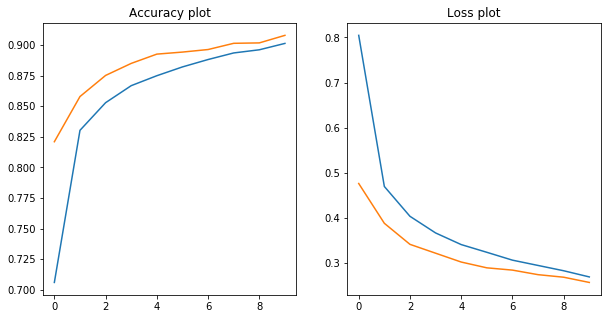

In [12]:
# 評估模型，計算成效
score=model.evaluate(Xtest4D,YtestOneHot)
print('loss=',score[0])
print('accuracy=',score[1])

#================ plot figure =======================

fig=plt.gcf()              # get current figure
fig.set_size_inches(10,5)  # 設置圖像長寬的具體尺寸(英吋)
                    
ax=plt.subplot(1,2,1)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('Accuracy plot')

ax=plt.subplot(1,2,2)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Loss plot')
plt.show()

## Step 6: Show Error Pictures

In [13]:
# 利用訓練好的模型進行預測
pred=list(model.predict_classes(Xtrain4D))
print(len(pred))
print(type(YtrainO),Ytrain.shape)
dataDict={'pred':pred, 'ans':YtrainO}
print(type(dataDict))

60000
<class 'numpy.ndarray'> (60000,)
<class 'dict'>


In [14]:
import pandas as pd

# 計算預測錯誤的數量
data=pd.DataFrame(dataDict)
idx=data[data.ans!=data.pred].index
idx=list(idx)
num=len(idx)
print(num)

5991


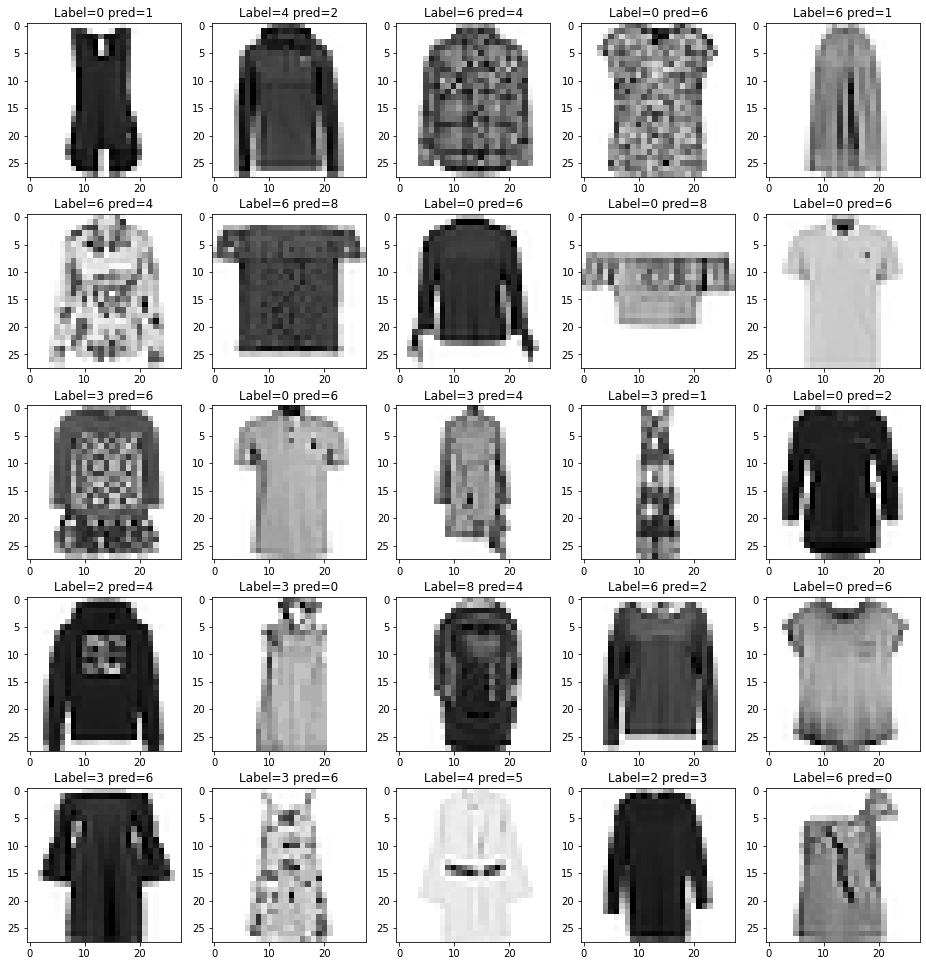

In [15]:
fig=plt.gcf()               # get current figure
fig.set_size_inches(16,17)  # 設置圖像長寬的具體尺寸(英吋)

# 印出前五十組預測錯誤的圖片
for i in range(25):
    ax=plt.subplot(5,5,i+1)
    ax.imshow(XtrainO[idx[i]], cmap='binary')    
    ax.set_title('Label={} pred={}'.format(YtrainO[idx[i]],pred[idx[i]]))

# plt.show()                